# Quantifying SAM's performance with clustering consensus metrics on multi-class segmentation of crops in satellite imagery using uniformly distributed prompting

 * File Created: Sunday, 14th May 2023 9:10:24 pm
 * Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.13.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

## Download SAM weights

Find explanation of SAM's parameters here - 
(SAM paper) https://arxiv.org/abs/2304.02643
(Blog) https://replicate.com/pablodawson/segment-anything-automatic

In [4]:
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-20 16:57:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘cached_models/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.2MB/s    in 23s     

2023-06-20 16:57:43 (106 MB/s) - ‘cached_models/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-06-20 16:57:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [

## Testing Clusterings Consensus Metrics

In [5]:
from sklearn import metrics
def eval_clustering(labels_true, labels_pred):
    # ri = metrics.rand_score(labels_true, labels_pred)
    # true_labels_entropy, pred_labels_entropy = scipy.stats.entropy(labels_true), scipy.stats.entropy(labels_pred)
    # true_labels_info_gain, pred_labels_info_gain = scipy.stats.entropy(labels_true) / len(set(labels_true)), scipy.stats.entropy(labels_pred) / len(set(labels_pred))
    # kl_div = 1 - scipy.stats.entropy(labels_pred, qk=labels_true)
    ari = np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 3)
    mi = np.round(metrics.mutual_info_score(labels_true, labels_pred), 3)
    ami = np.round(metrics.adjusted_mutual_info_score(labels_true, labels_pred), 3)
    nmi = np.round(metrics.normalized_mutual_info_score(labels_true, labels_pred), 3)
    h = np.round(metrics.homogeneity_score(labels_true, labels_pred), 3)
    c = np.round(metrics.completeness_score(labels_true, labels_pred), 3)
    v = np.round(metrics.v_measure_score(labels_true, labels_pred), 3)
    fmi = np.round(metrics.fowlkes_mallows_score(labels_true, labels_pred), 3)

    return pd.Series([fmi,ari,mi,ami,nmi,h,c,v, 
                    #   true_labels_entropy, pred_labels_entropy, true_labels_info_gain, pred_labels_info_gain, kl_div
                    ], 
                     index=['FMI','ARI','MI','AMI','NMI','Homogeneity','Completeness','V-Measure',
                            # 'true_entropy', 'pred_entropy','true_info_gain', 'pred_info_gain', 'KL_divergence'
                        ])

## Test Cases:

### case: #1
# labels_true = [0, 0, 0, 1, 1, 1]
# labels_pred = [10, 10, 11, 11, 12, 12]
# result = eval_clustering(labels_true, labels_pred)

### case: #2
# import random
# labels_true = random.sample(range(0,10), 6)
# labels_pred = random.sample(range(11,20), 6)
# print(labels_true, labels_pred)
# result = eval_clustering(labels_true, labels_pred)

### case: Mismatch in minority clusters 
labels_true = [10]*100+[1]*5
labels_pred = [3]*105
print()
print(eval_clustering(labels_true, labels_pred))

labels_true = [10]*1000+[1]*5
labels_pred = [3]*1005
print()
print(eval_clustering(labels_true, labels_pred))

labels_true = [10]*10000+[1]*5
labels_pred = [3]*10005
print()
print(eval_clustering(labels_true, labels_pred))

## case: equally distributed labels
labels_true = [10]*500 + [1]*500
labels_pred = [3]*800 + [2]*200
print()
print(eval_clustering(labels_true, labels_pred))

print("\n---> Perfect Clustering match <---")
labels_true = [10]*1000
labels_pred = [11]*1000
print()
print(eval_clustering(labels_true, labels_pred))


FMI             0.953
ARI             0.000
MI              0.000
AMI             0.000
NMI             0.000
Homogeneity     0.000
Completeness    1.000
V-Measure       0.000
dtype: float64

FMI             0.995
ARI             0.000
MI             -0.000
AMI            -0.000
NMI            -0.000
Homogeneity    -0.000
Completeness    1.000
V-Measure      -0.000
dtype: float64

FMI             1.0
ARI             0.0
MI              0.0
AMI             0.0
NMI             0.0
Homogeneity     0.0
Completeness    1.0
V-Measure       0.0
dtype: float64

FMI             0.651
ARI             0.159
MI              0.164
AMI             0.274
NMI             0.275
Homogeneity     0.236
Completeness    0.328
V-Measure       0.275
dtype: float64

---> Perfect Clustering match <---

FMI             1.0
ARI             1.0
MI              0.0
AMI             1.0
NMI             1.0
Homogeneity     1.0
Completeness    1.0
V-Measure       1.0
dtype: float64


## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### Visualize Samples

In [6]:
## PPS as fraction of image length and width
aoi_length = 137
print("PPS")
pps_frac_vals =  [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1] #[1e-1, 1.25e-1, 2.5e-1]
print(pps_frac_vals, [f"{pps_frac*100}%" for pps_frac in pps_frac_vals])
pps_vals = [np.ceil(aoi_length*pps_frac).astype(int) for pps_frac in pps_frac_vals]
print(pps_vals)

## MMRA as a fraction of image area
print("MMRA")
min_mask_region_fracs_vals = [1e-3, 5*1e-3, 1e-2, 5*1e-2, 1e-1]
print(min_mask_region_fracs_vals, [f"{min_mask_region_frac*100}%" for min_mask_region_frac in min_mask_region_fracs_vals])
min_mask_region_area_vals = [np.ceil(aoi_length*aoi_length*min_mask_region_frac).astype(int) for min_mask_region_frac in min_mask_region_fracs_vals]
print(min_mask_region_area_vals)

PPS
[0.01, 0.025, 0.05, 0.075, 0.1] ['1.0%', '2.5%', '5.0%', '7.5%', '10.0%']
[2, 4, 7, 11, 14]
MMRA
[0.001, 0.005, 0.01, 0.05, 0.1] ['0.1%', '0.5%', '1.0%', '5.0%', '10.0%']
[19, 94, 188, 939, 1877]


In [10]:
aoi_sizes = [1098, 549, 274, 137, 68]
aoi_size = aoi_sizes[0]
SAMPLES_DIR = "/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_{}".format(aoi_size)
sample_filepaths = sorted(glob.glob(SAMPLES_DIR+"/*.npy"))
print(len(sample_filepaths), sample_filepaths[:2])

347 ['/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_1_9_sample_86_maxNDVItimestep_rgb_size_1098.npy', '/data/rgura001/AI4CP.data/sam4crops/aoi_samples/overlap_0.5/DATAPOINTS_maxNDVItimestep_rgb_size_1098/T10SEH_2018_2_1_sample_29_maxNDVItimestep_rgb_size_1098.npy']


In [11]:
num_samples=10
num_avail_samples = len(sample_filepaths)
if num_avail_samples >= num_samples:
    np.random.seed(42)
    sample_idxes = np.random.randint(low=0, high=num_avail_samples, size=num_samples)
else:
    print("num_samples greater than num_avail_samples(={})! Exiting...".format(num_avail_samples))
    # sys.exit()
print(sample_idxes)

[102 270 106  71 188  20 102 121 214 330]


106 (1098, 1098, 4)
(1098, 1098, 3) (1098, 1098)


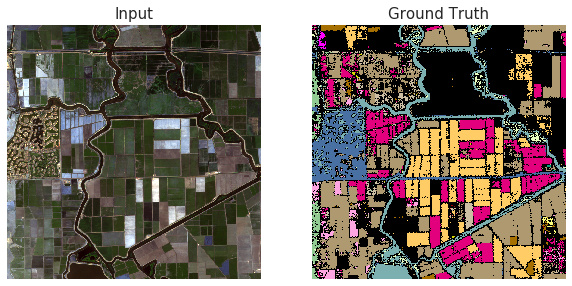

In [12]:
i = 2
sample_id = sample_idxes[i]
sample = np.load(sample_filepaths[sample_id])    
print(sample_idxes[i], sample.shape)

image, gt_mask = sample[...,:3].astype('uint8'), sample[...,-1] ## because SAM expects uint8 inputs
print(image.shape, gt_mask.shape)

from utils import plot_sample
plot_sample(img=image, mask=gt_mask)

In [13]:
num_classes_in_gt_mask = len(np.unique(gt_mask))
num_classes_in_gt_mask

20

### Visualize Prediction

In [14]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "../cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)

/home/rgura001/segment-anything/sam4crops/cached_models/sam_vit_h_4b8939.pth


Full explanation of all options available in `SamAutomaticMaskGenerator` can be found here - https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [15]:
from utils import plot_prediction, eval_clustering

img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs_vals = [1e-1]
# min_mask_area_vals = [int(min_mask_area_frac*img_w*img_h) for min_mask_area_frac in min_mask_region_frac_vals]
pps_vals = [32]
crop_n_layers_vals = [1]
crop_n_points_downscale_factor = 1

for pps in pps_vals:
    for min_mask_area_frac in tqdm(min_mask_region_fracs_vals, leave=False):
        min_mask_area = int(min_mask_area_frac*img_w*img_h)
        min_mask_area_perc = min_mask_area_frac*100
        for crop_n_layers in crop_n_layers_vals:
            # for crop_n_points_downscale_factor in crop_n_points_downscale_factor_vals:
            # try:
            print(crop_n_layers, crop_n_points_downscale_factor)
            
            titlestr = "AOI=({}x{}) (SAM params: PPS={}, MMRA={}% of AOI, crop_n_layers={})"\
                        .format(img_w, img_h, pps, min_mask_area_perc, crop_n_layers)
            # print(titlestr)

            print("Defining mask generator...")
            mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                        points_per_side=pps,
                                                        pred_iou_thresh=0.95,
                                                        stability_score_thresh=0.95,
                                                        # box_nms_thresh=0.0,
                                                        # crop_nms_thresh=0.0,
                                                        crop_n_layers=crop_n_layers,
                                                        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                                        min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                    )
            print("DONE!")

            print("Generating masks...")
            masks = mask_generator.generate(image)
            print(masks[0].keys())
            print("For sample {}, SAM generated {} boolean masks!".format(sample_id, len(masks)))
            ## Sort masks by stability score
            masks = sorted(masks, key=lambda d: d['stability_score']) 

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Checking for any overlap in the masks
            # bin_masks = np.array([np.array(mask['segmentation']).astype(int) for mask in masks])
            # print(collections.Counter(bin_masks.flatten()))
            # pred_mask = np.sum(bin_masks, axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean overlapping masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            # pred_mask = masks[0]['segmentation'].astype(int)
            for i in range(len(masks)):
                val = i+1
                pred_mask += masks[i]['segmentation'].astype(int) * val
                pred_mask = np.where(pred_mask > val, val, pred_mask)
            pred_mask = pred_mask.astype('uint8')
            print(f"Max cluster id = {pred_mask.flatten().max()}")
            print(f"num_labels_in_pred_mask = {len(np.unique(pred_mask))}")
            print("DONE!")

            print("Evaluating clustering consensus...")

  0%|          | 0/1 [00:00<?, ?it/s]

1 1
Defining mask generator...
DONE!
Generating masks...


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
For sample 106, SAM generated 413 boolean masks!
Max cluster id = 255
num_labels_in_pred_mask = 248
DONE!
Evaluating clustering consensus...


In [12]:
# import json_tricks
# masks_dict = {}
# masks_dict[str(sample_id)] = masks
# SAVE_DIR = "/home/rgura001/segment-anything/sam4crops/results/nbk"
# with open(SAVE_DIR+"/predicted_masks.json", "w") as fp:
#     json_tricks.dump(masks_dict, fp)

# masks_dict_loaded = json_tricks.load(open(SAVE_DIR+"/predicted_masks.json", "r"))
# print(dict(masks_dict_loaded).keys())
# print(dict(masks_dict_loaded[str(sample_id)][0]).keys())

In [13]:

pprint(list(mask_generator.__dict__.keys()))

['point_grids',
 'predictor',
 'points_per_batch',
 'pred_iou_thresh',
 'stability_score_thresh',
 'stability_score_offset',
 'box_nms_thresh',
 'crop_n_layers',
 'crop_nms_thresh',
 'crop_overlap_ratio',
 'crop_n_points_downscale_factor',
 'min_mask_region_area',
 'output_mode']


### Visualize grid search results

In [5]:
RESULTS_DIR = "../results"

##### Sample Size = 300

In [6]:
num_samples = 300
aoi_sizes = [137, 274, 549] #[1098, 549, 274, 137]
results = []
for aoi_size in aoi_sizes:
    results.append(pd.read_csv(RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/results.csv".format(num_samples, aoi_size)))
results = pd.concat(results)
results['#pred_labels-#gt_labels'] = results['num_labels_in_pred_mask'] - results['num_labels_in_gt_mask']
results

sample_idx  aoi  pps  pps_perc   mmra  mmra_perc  crop_n_layers  \
0          23852  137    2       1.0     19        0.1              1   
1          62023  137    2       1.0     19        0.1              1   
2          75037  137    2       1.0     19        0.1              1   
3          59105  137    2       1.0     19        0.1              1   
4          13143  137    2       1.0     19        0.1              1   
...          ...  ...  ...       ...    ...        ...            ...   
7495         809  549   55      10.0  30141       10.0              1   
7496        2858  549   55      10.0  30141       10.0              1   
7497        3113  549   55      10.0  30141       10.0              1   
7498          25  549   55      10.0  30141       10.0              1   
7499        2726  549   55      10.0  30141       10.0              1   

      crop_n_points_downscale_factor  nms_thresh    FMI    ARI     MI    AMI  \
0                                  1         0.7  0.449  0.193  0.383  0.291   
1                                  1         0.7  0.511  0.238  0.428  0.327   
2                                  1         0.7  0.399  0.090  0.460  0.328   
3                                  1         0.7  0.874  0.642  0.272  0.447   
4                                  1         0.7  0.588  0.273  0.270  0.273   
...                              ...         ...    ...    ...    ...    ...   
7495                               1         0.7  0.307  0.091  0.548  0.258   
7496                               1         0.7  0.343  0.185  0.877  0.323   
7497                               1         0.7  0.215  0.009  0.489  0.216   
7498                               1         0.7  0.173  0.064  1.381  0.427   
7499                               1         0.7  0.152  0.034  1.006  0.308   

        NMI  Homogeneity  Completeness  V-Measure  num_labels_in_pred_mask  \
0     0.291        0.337         0.256      0.291                      5.0   
1     0.328        0.321         0.335      0.328                      5.0   
2     0.329        0.311         0.349      0.329                      6.0   
3     0.447        0.409         0.493      0.447                      2.0   
4     0.273        0.210         0.390      0.273                      2.0   
...     ...          ...           ...        ...                      ...   
7495  0.258        0.575         0.167      0.258                     89.0   
7496  0.324        0.539         0.232      0.324                    240.0   
7497  0.217        0.494         0.139      0.217                     84.0   
7498  0.428        0.730         0.303      0.428                    161.0   
7499  0.309        0.604         0.208      0.309                    243.0   

      num_labels_in_gt_mask  #pred_labels-#gt_labels  
0                       4.0                      1.0  
1                      12.0                     -7.0  
2                      10.0                     -4.0  
3                      10.0                     -8.0  
4                       7.0                     -5.0  
...                     ...                      ...  
7495                    9.0                     80.0  
7496                   20.0                    220.0  
7497                    9.0                     75.0  
7498                   17.0                    144.0  
7499                   19.0                    224.0  

[22500 rows x 20 columns]

In [7]:
print(collections.Counter(results['pps_perc']))
print(len(set(results['sample_idx'])))

Counter({1.0: 4500, 2.5: 4500, 5.0: 4500, 7.5: 4500, 10.0: 4500})
905


#### Aggregate Violin Plots

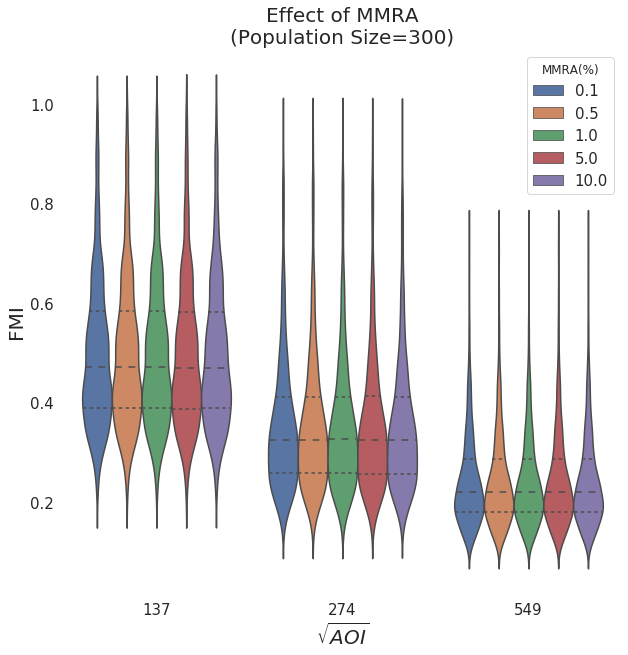

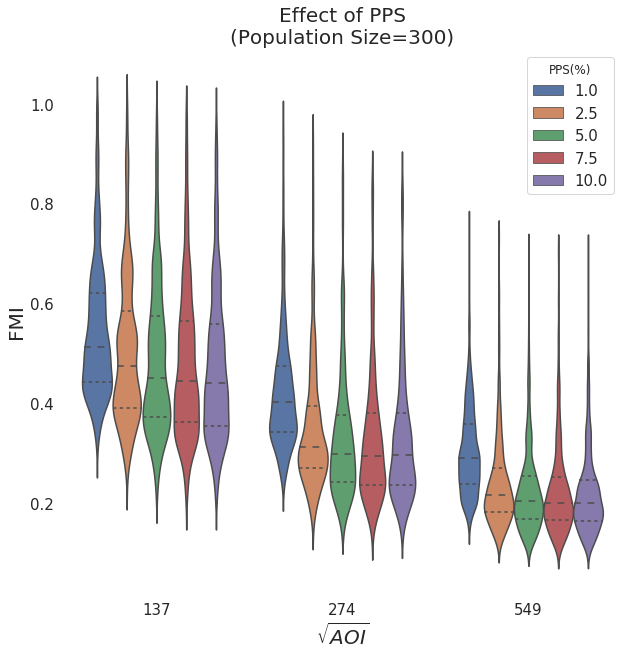

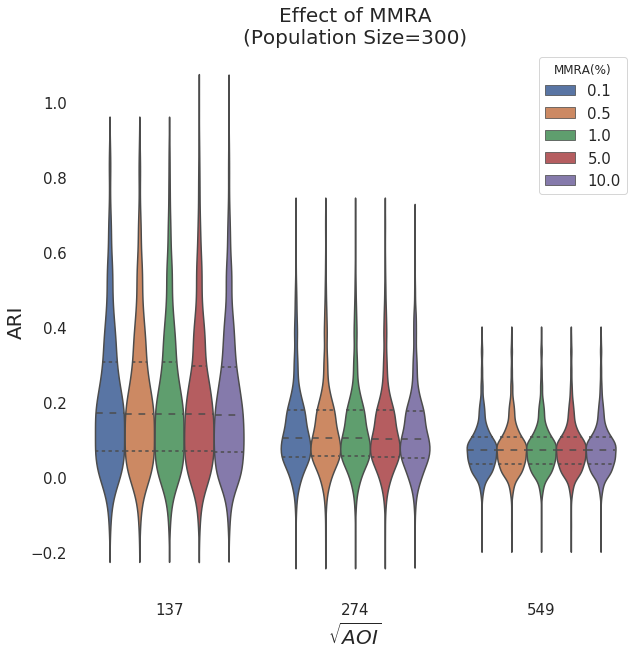

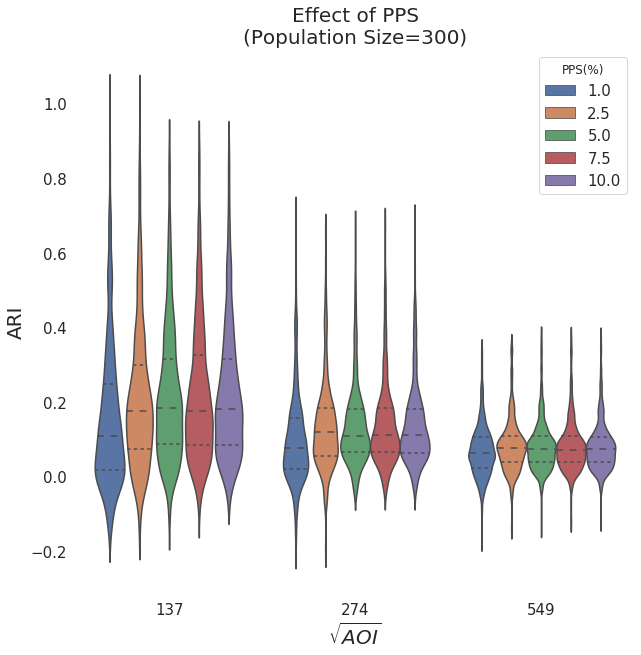

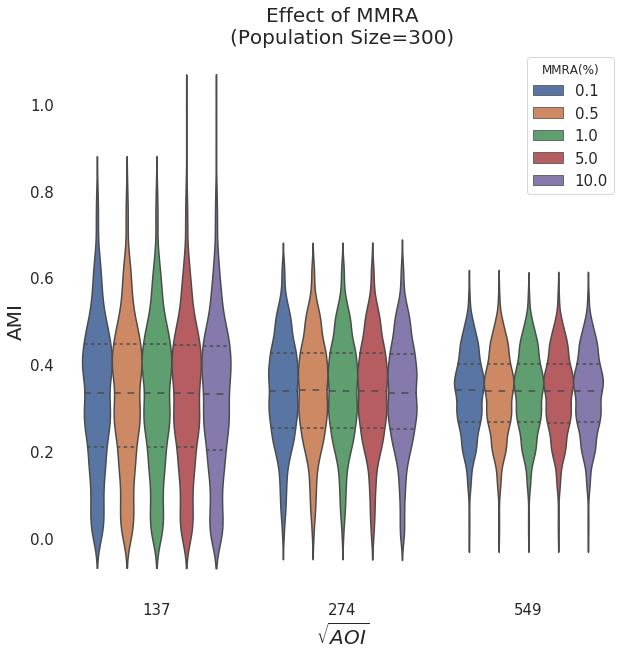

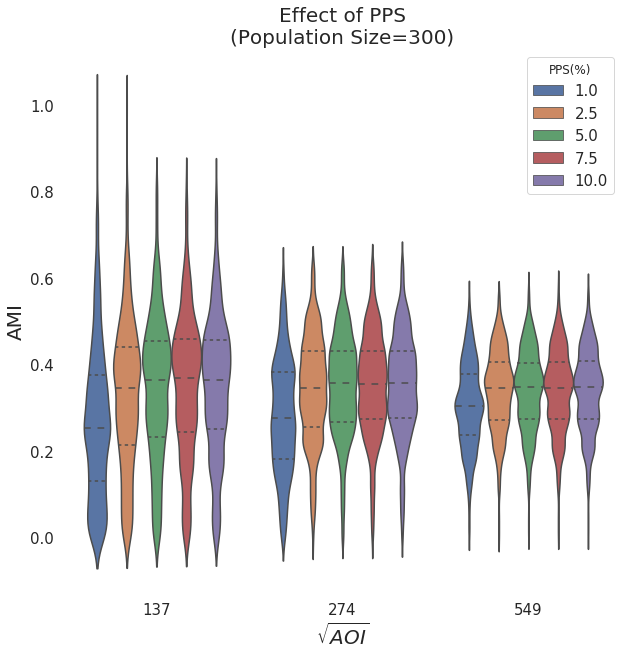

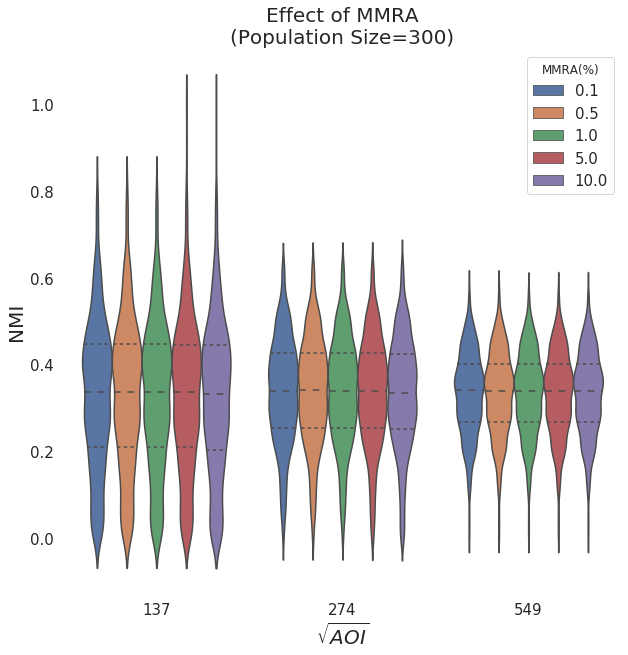

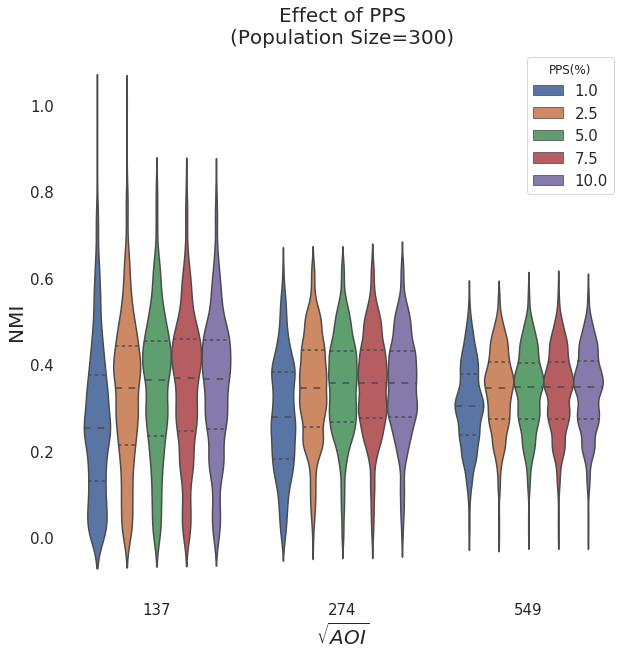

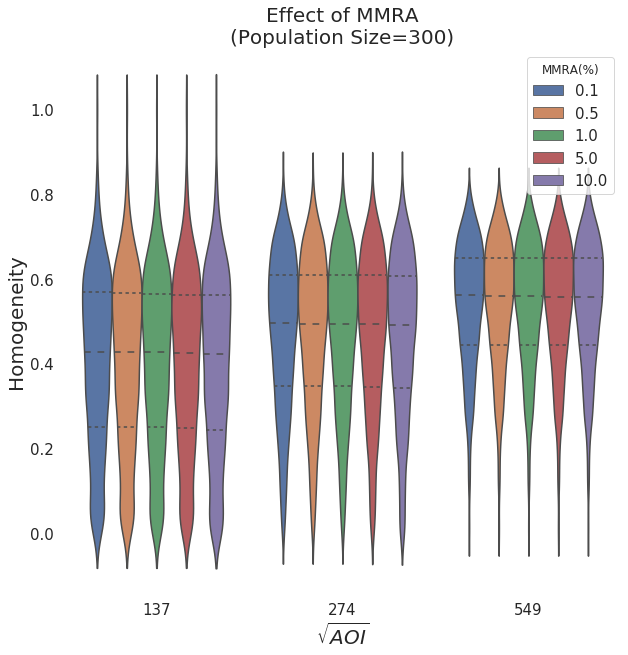

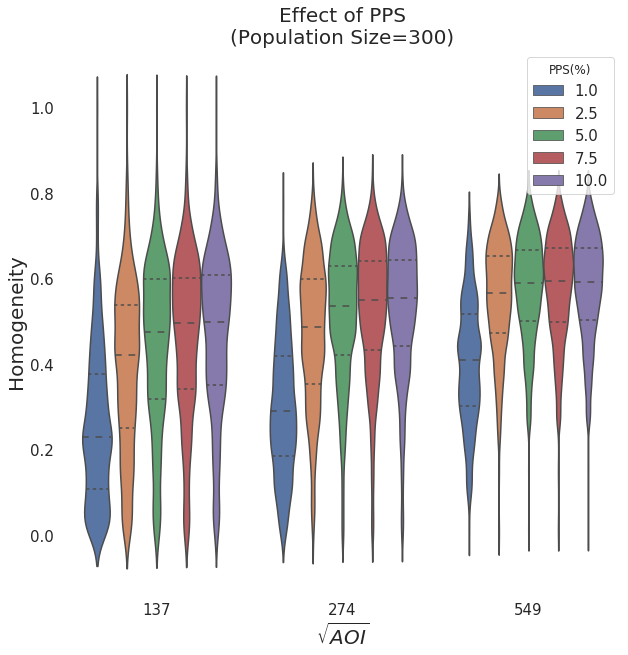

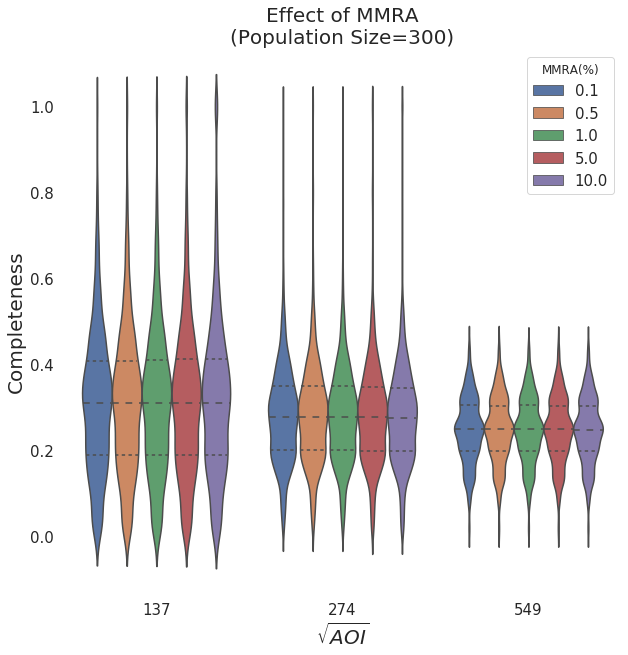

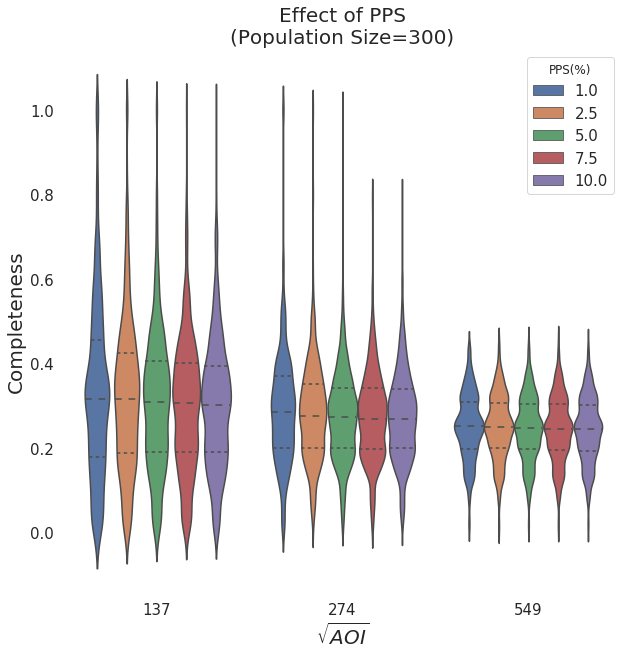

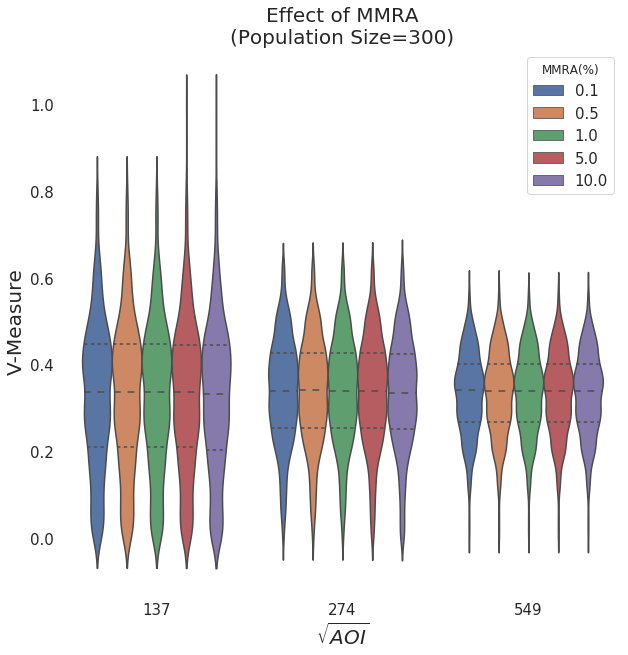

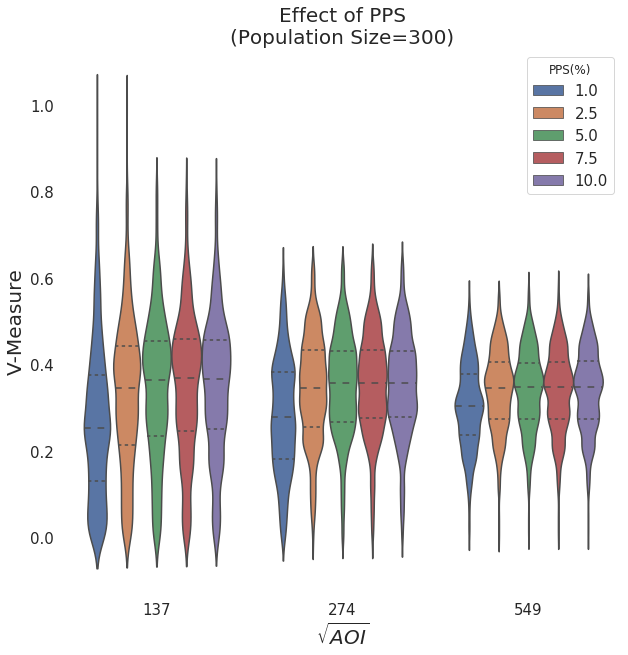

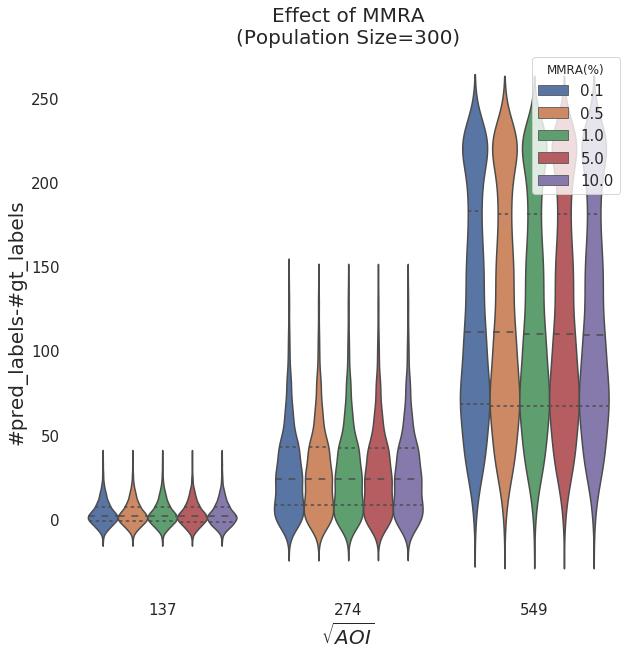

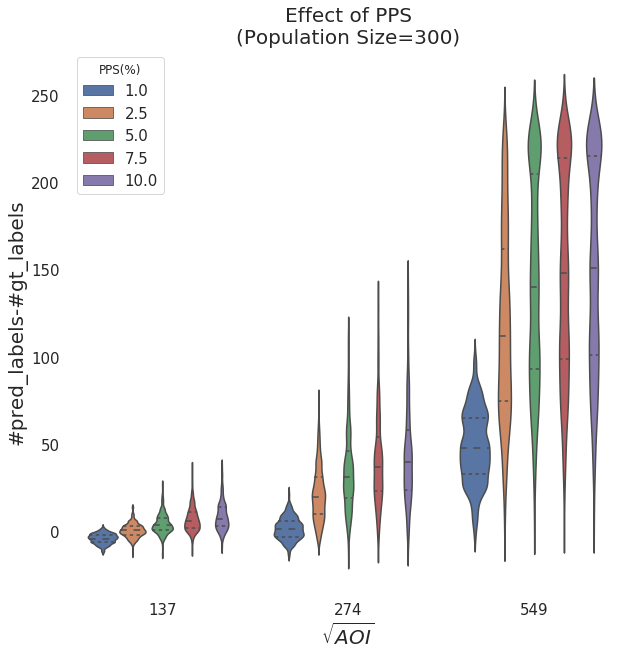

In [16]:
metrics = ['FMI', 'ARI', 'AMI', 'NMI', 
           'Homogeneity', 'Completeness', 'V-Measure',
           '#pred_labels-#gt_labels'
        ]
metrics_bounds = [(-0.1,1.1), (-1.1,1.1), (-0.1,1.1), (-0.1,1.1),
                    (-0.1,1.1), (-0.1,1.1), (-0.1,1.1)
                ]
x = results['aoi'].astype(str)
for metric in metrics:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=15)

    plot = sns.violinplot(data=results, x="aoi", y=metric, hue="mmra_perc", 
                    bw = 0.2,  cut=2,
                    inner='quartile', ax=ax)
    # plot = sns.lineplot(data=results, x=x, y=metric, hue="mmra_perc", ax=ax)
    plot.set_ylabel(plot.get_ylabel(), size=20)
    plot.set_xlabel(plot.get_xlabel(), size=20)
    ax.set_title(f"Effect of MMRA\n(Population Size={num_samples})", fontsize=20)
    # ax.set_ylim(metrics_bounds[metrics.index(metric)])
    ax.set_xlabel(r"$\sqrt{AOI}$", fontsize=20)
    ax.legend(loc="best", fontsize=15, title="MMRA(%)")
    

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=15)
    plot = sns.violinplot(data=results, x="aoi", y=metric, hue="pps_perc", 
                    bw = 0.2,  cut=2,
                    inner='quartile', ax=ax)
    plot = sns.lineplot(data=results, x=x, y=metric, hue="pps_perc", ax=ax)
    plot.set_ylabel(plot.get_ylabel(), size=20)
    plot.set_xlabel(plot.get_xlabel(), size=20)
    ax.set_title(f"Effect of PPS\n(Population Size={num_samples})", fontsize=20)
    # ax.set_ylim(metrics_bounds[metrics.index(metric)])
    ax.set_xlabel(r"$\sqrt{AOI}$", fontsize=20)
    ax.legend(loc="best", fontsize=15, title="PPS(%)")

    plt.show()


In [13]:
results = results.sort_values(by=['FMI'], ascending=False)
# results[(results.FMI.between(0.5, 0.9, inclusive=True)) & (results.AOI == 1098) & (results.PPS == 4)]
results

sample_idx  aoi  pps  pps_perc  mmra  mmra_perc  crop_n_layers  \
5026       41554  137    4       2.5  1877       10.0              1   
3827       41554  137    4       2.5   939        5.0              1   
5326       41554  137    7       5.0  1877       10.0              1   
4127       41554  137    7       5.0   939        5.0              1   
1429       41554  137    4       2.5    94        0.5              1   
...          ...  ...  ...       ...   ...        ...            ...   
5734       33075  137   14      10.0  1877       10.0              1   
4234       33075  137   11       7.5   939        5.0              1   
3034       33075  137   11       7.5   188        1.0              1   
1834       33075  137   11       7.5    94        0.5              1   
934        33075  137   14      10.0    19        0.1              1   

      crop_n_points_downscale_factor  nms_thresh    FMI    ARI     MI    AMI  \
5026                               1         0.7  1.000  1.000  0.000  1.000   
3827                               1         0.7  1.000  1.000  0.000  1.000   
5326                               1         0.7  0.986  0.000  0.000  0.000   
4127                               1         0.7  0.986  0.000  0.000  0.000   
1429                               1         0.7  0.985  0.000  0.000  0.000   
...                              ...         ...    ...    ...    ...    ...   
5734                               1         0.7  0.208  0.016  0.380  0.179   
4234                               1         0.7  0.208  0.018  0.391  0.184   
3034                               1         0.7  0.208  0.018  0.391  0.184   
1834                               1         0.7  0.208  0.018  0.391  0.184   
934                                1         0.7  0.208  0.016  0.380  0.179   

        NMI  Homogeneity  Completeness  V-Measure  
5026  1.000        1.000         1.000      1.000  
3827  1.000        1.000         1.000      1.000  
5326  0.000        1.000         0.000      0.000  
4127  0.000        1.000         0.000      0.000  
1429  0.000        1.000         0.000      0.000  
...     ...          ...           ...        ...  
5734  0.182        0.315         0.128      0.182  
4234  0.188        0.325         0.132      0.188  
3034  0.188        0.325         0.132      0.188  
1834  0.188        0.325         0.132      0.188  
934   0.182        0.315         0.128      0.182  

[6000 rows x 17 columns]

Looks like, as expected, the high FMI samples have smaller AOI.

Let's take a look at samples in the tails and figure out what's different between samples in top and bottom tails.

#### Bottom tails

941


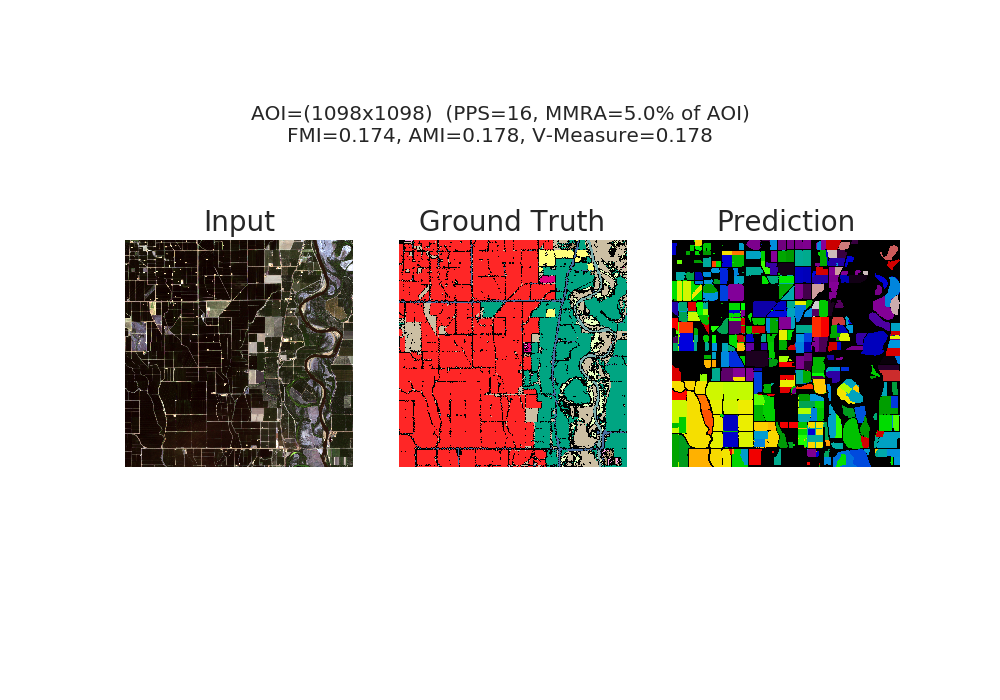

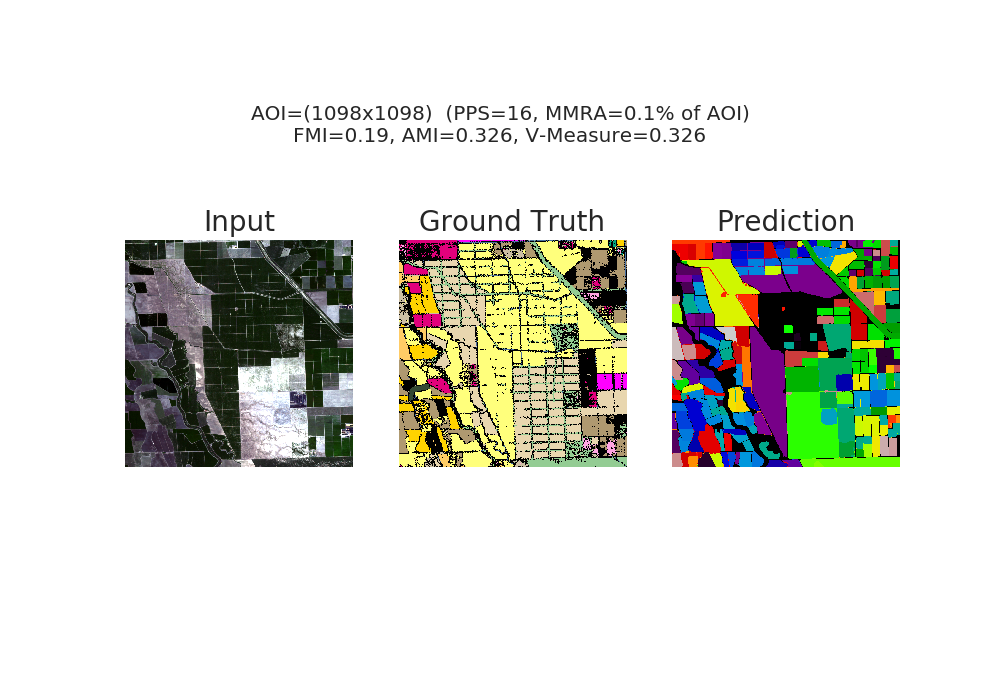

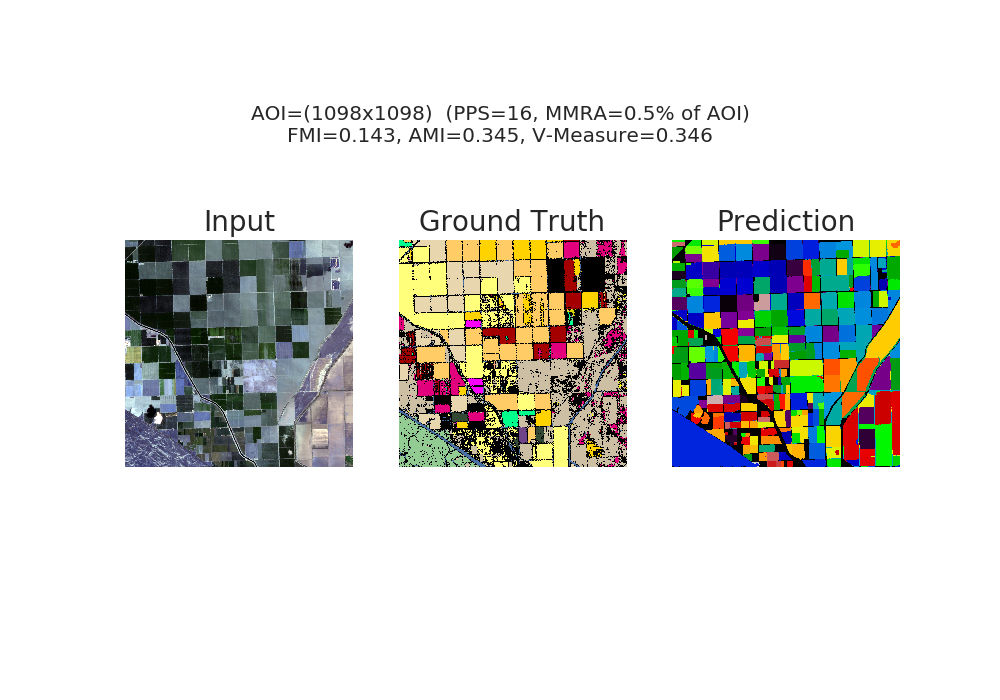

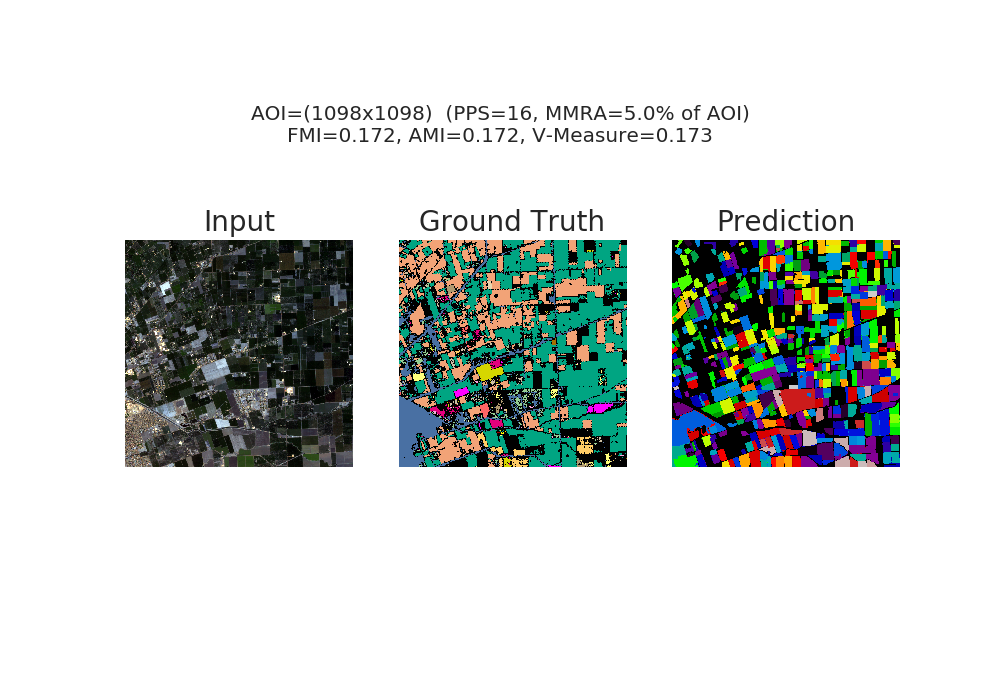

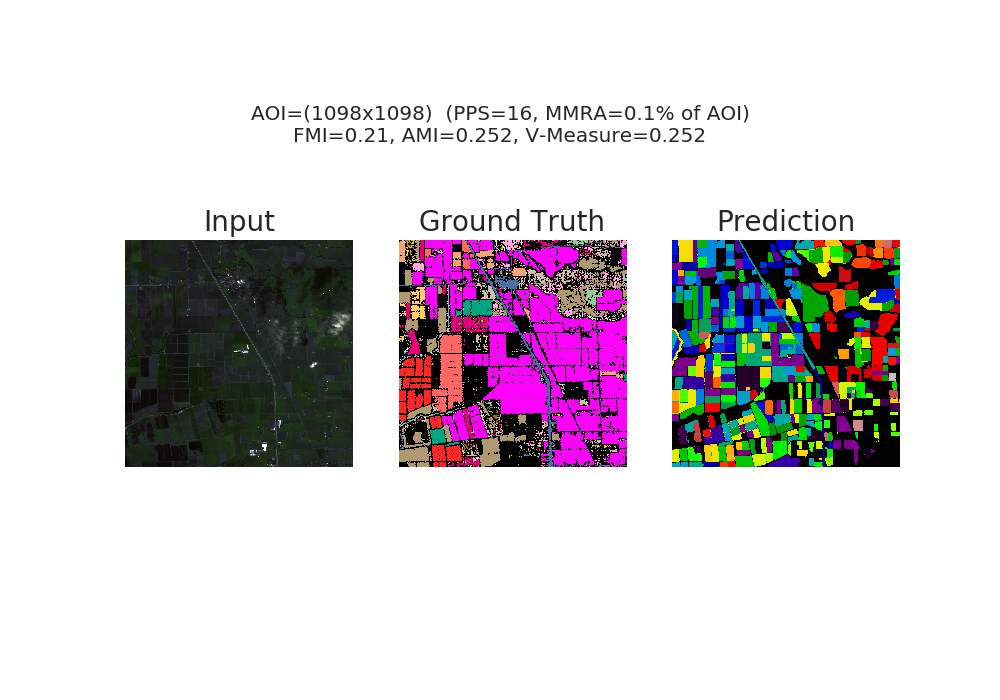

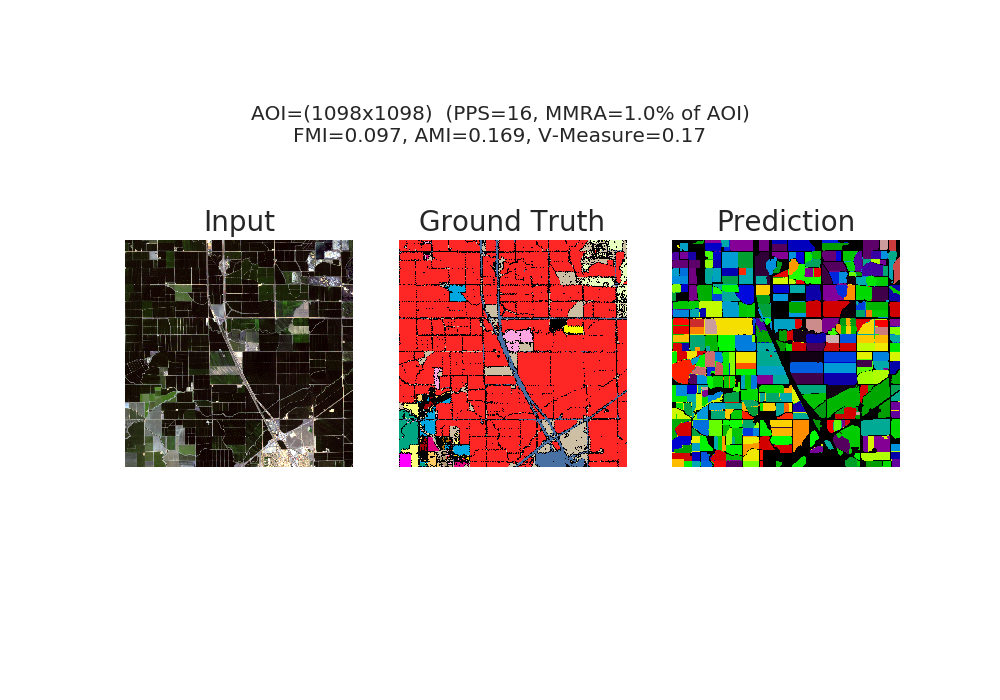

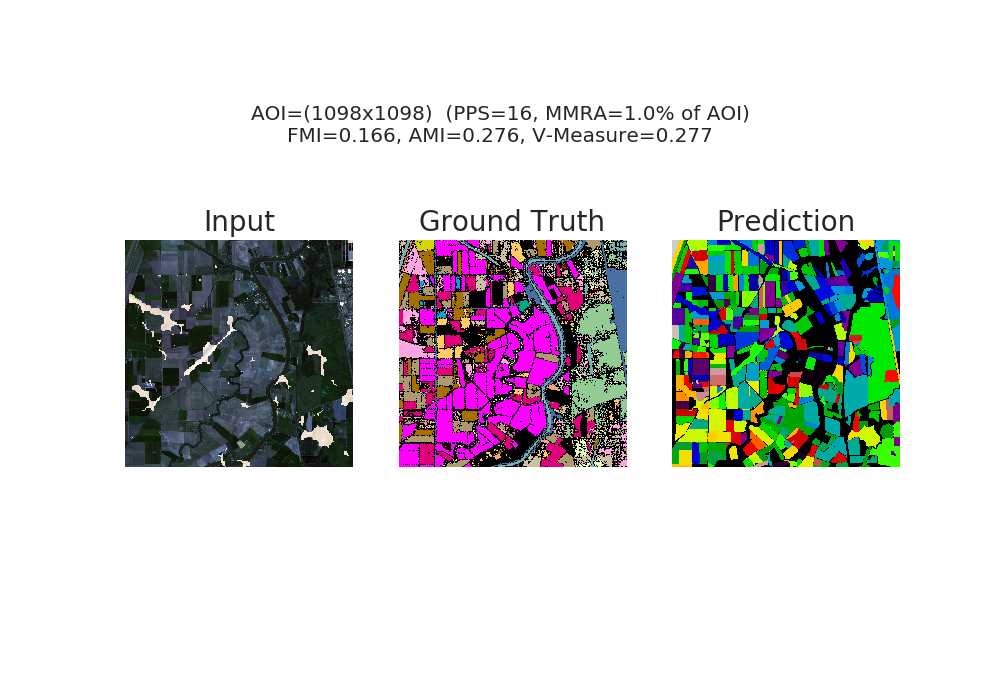

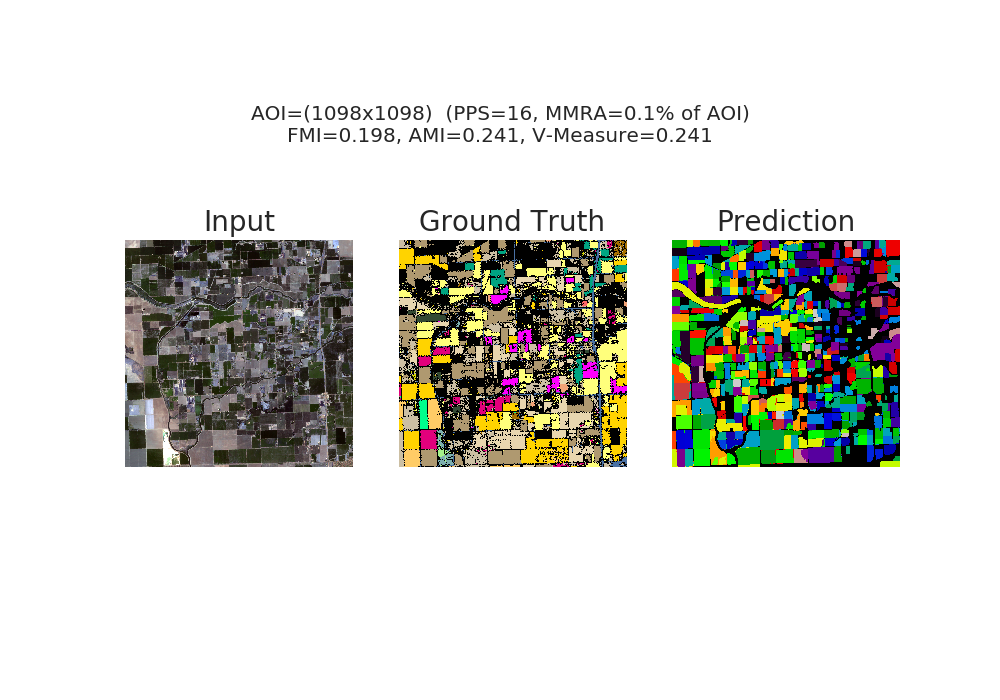

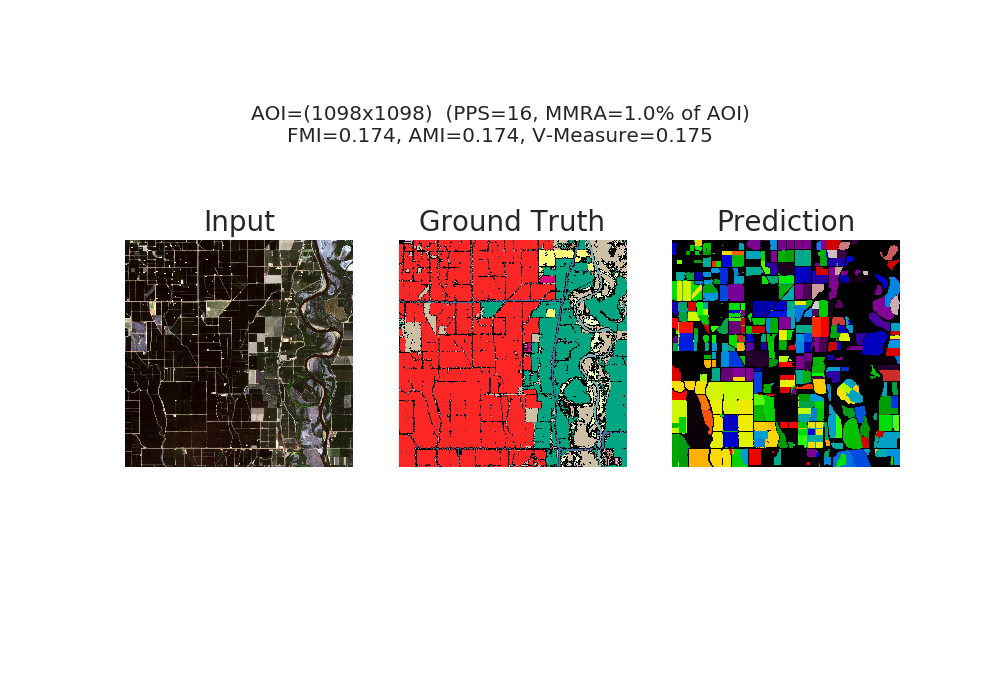

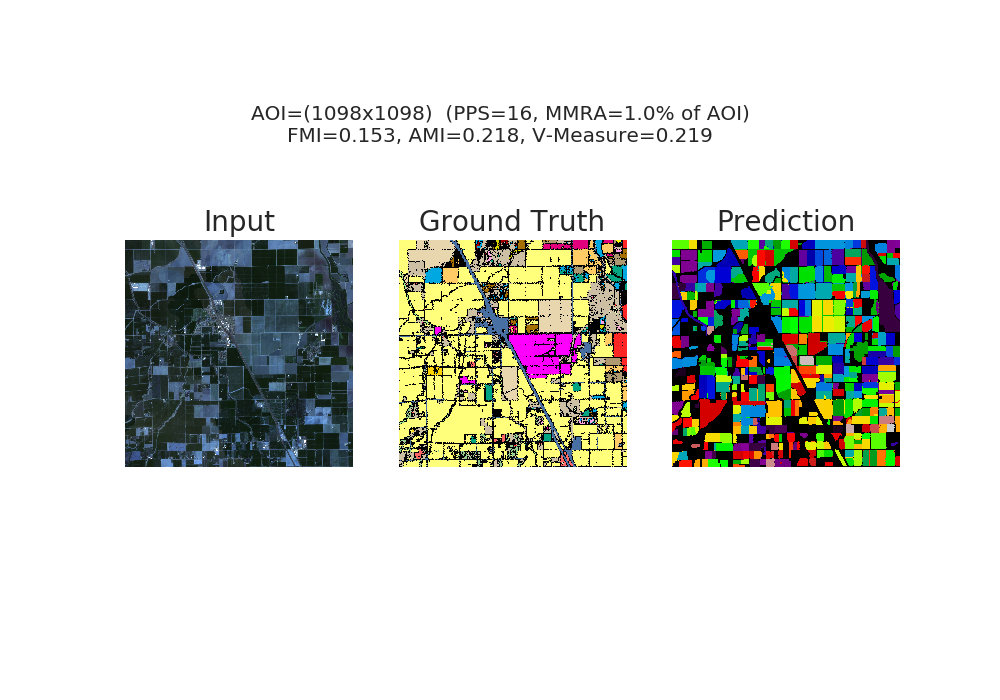

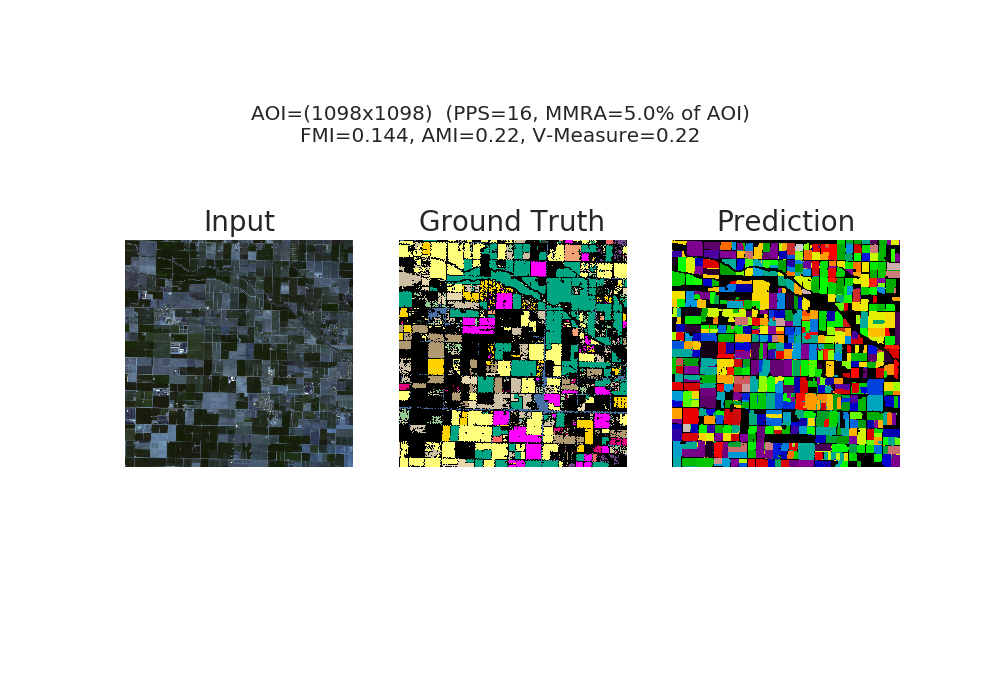

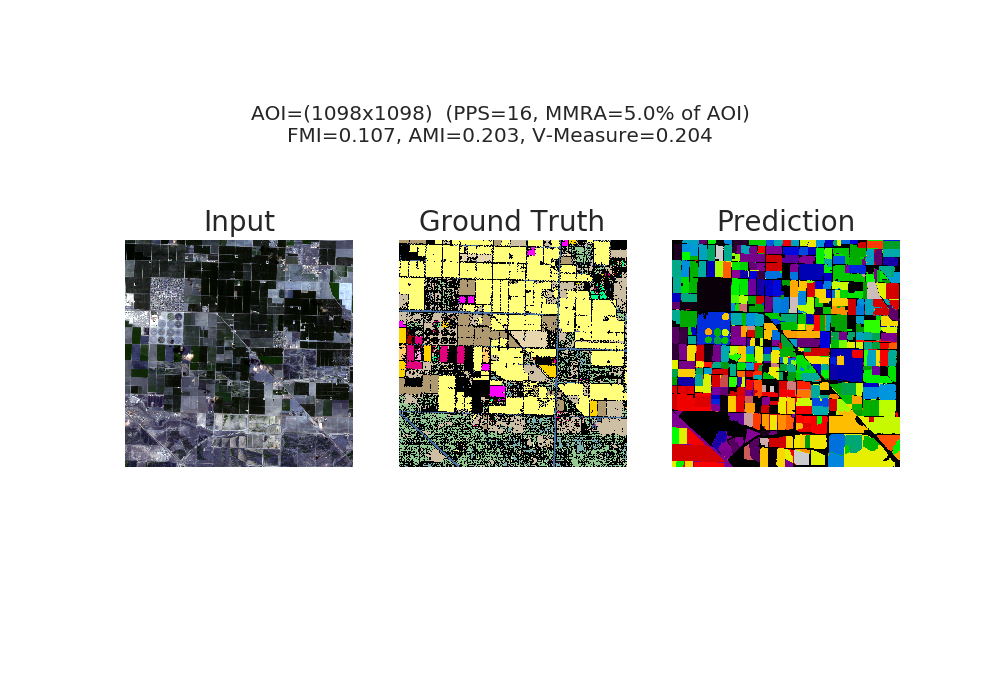

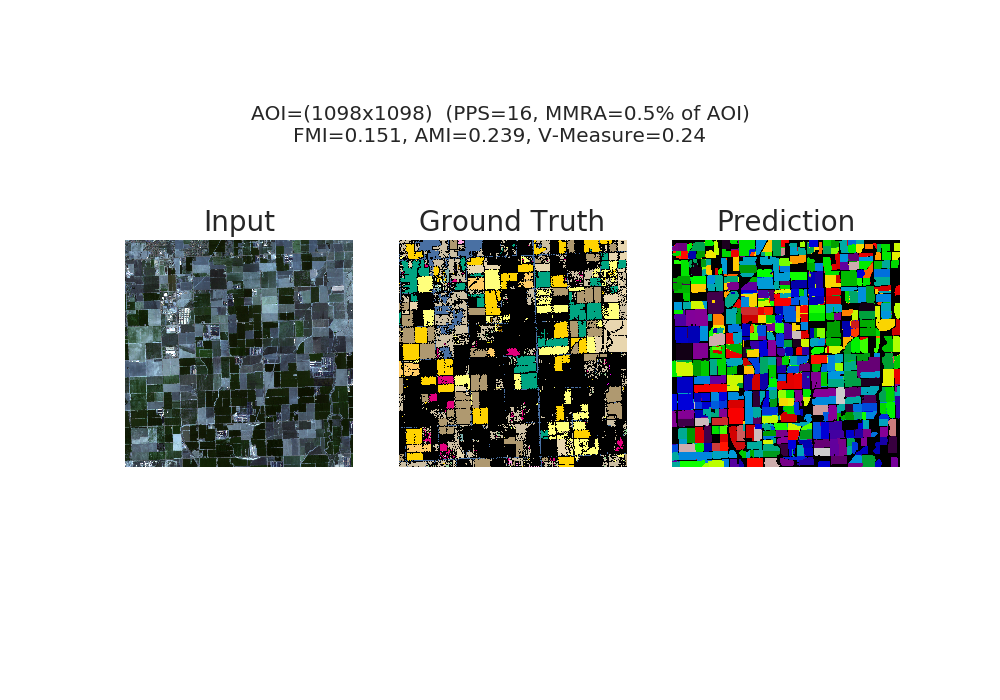

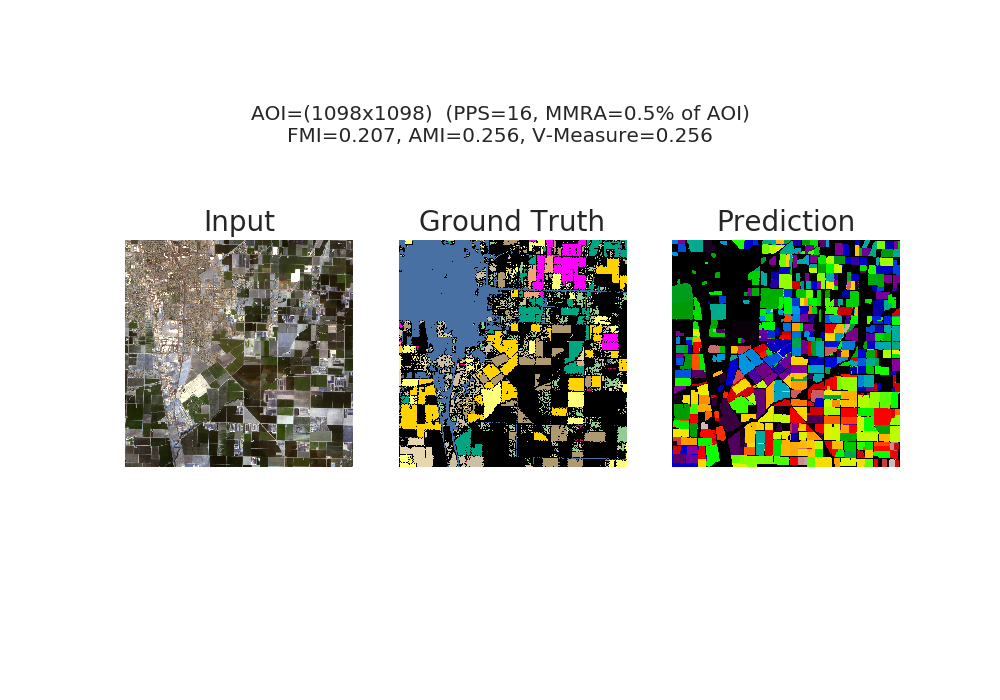

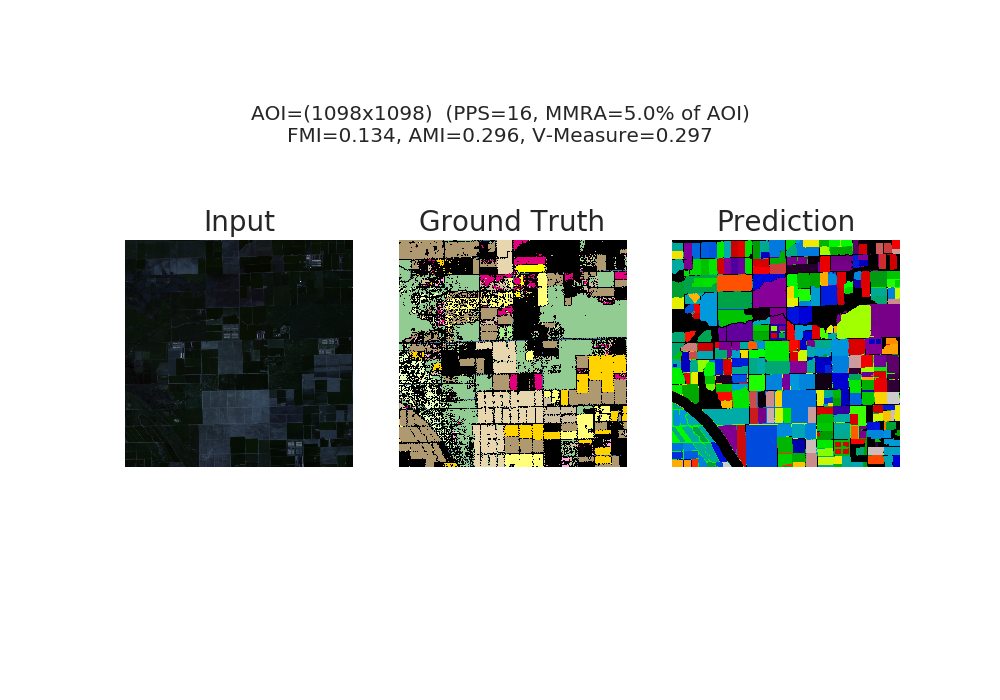

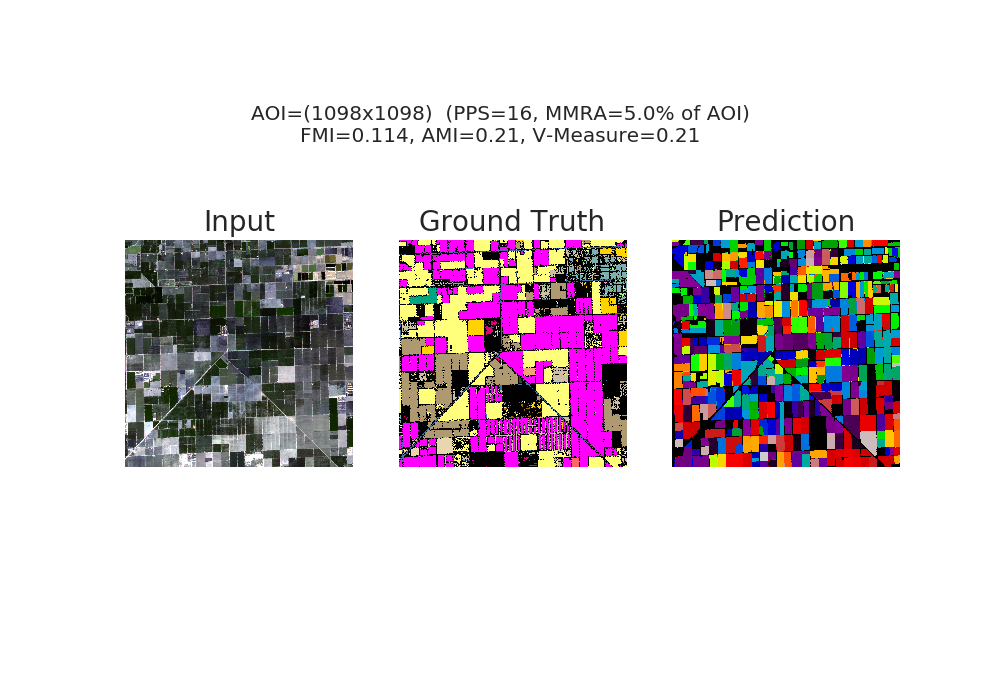

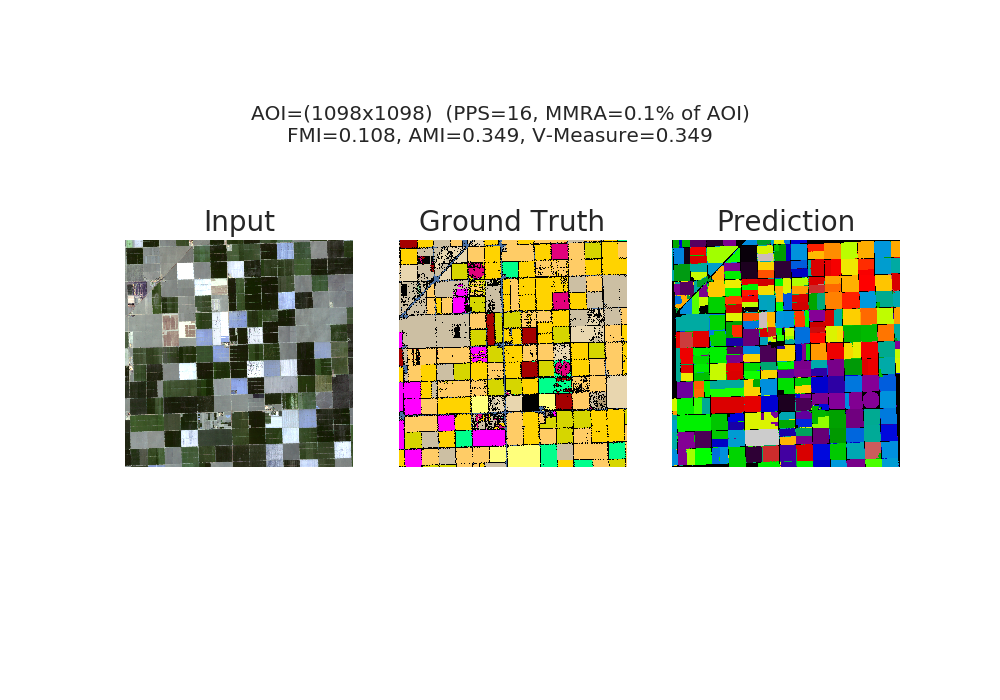

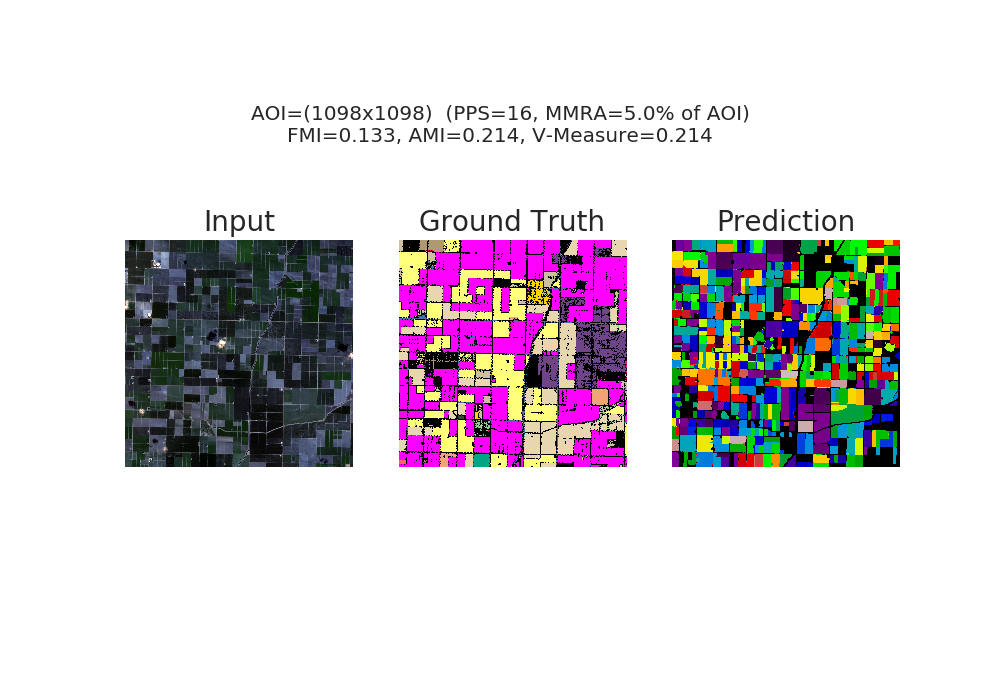

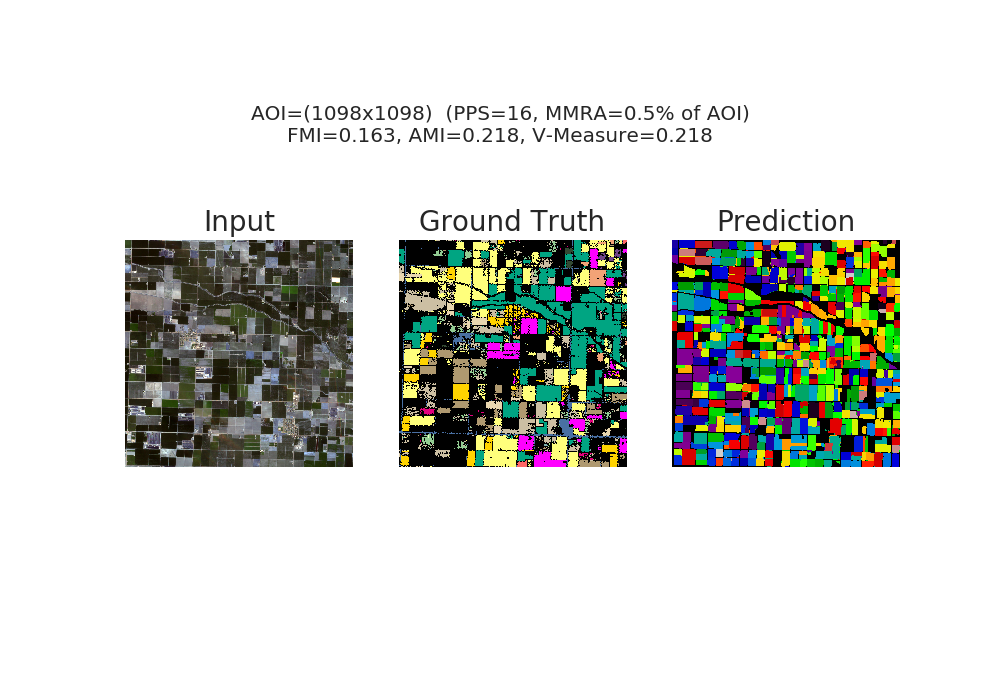

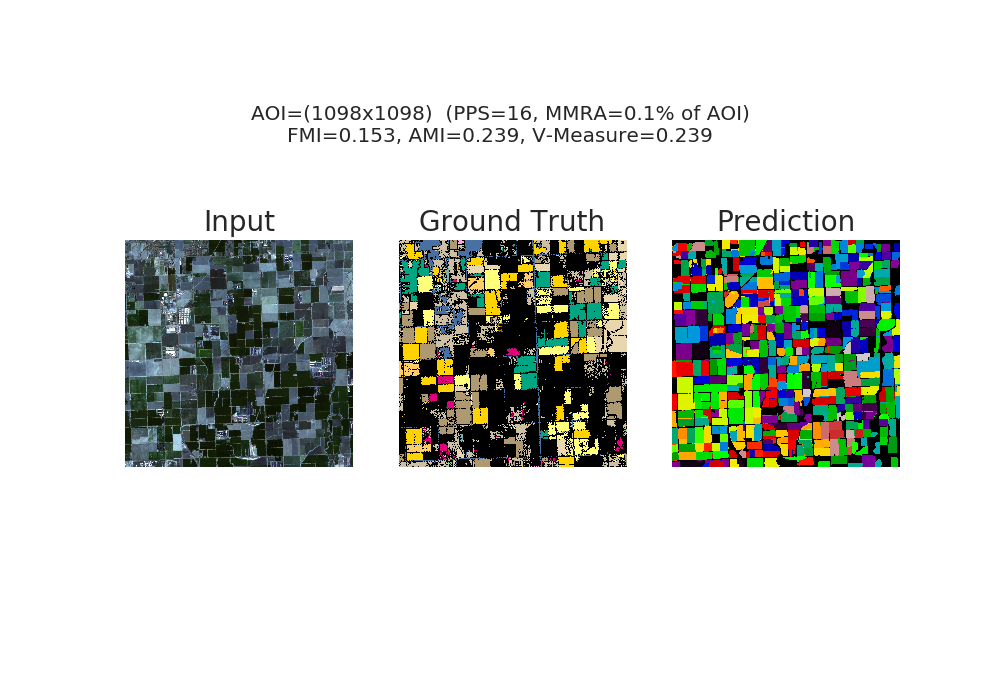

In [59]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.0, 0.21, inclusive=True)) 
                                & (results.AOI == 1098) 
                                & (results.PPS == 16)
                            ]
print(len(samples_to_display))

n=10
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(20)

for index, row in samples_to_display.iterrows():
    # print(row['sample_idx'], row['AOI'], row['PPS'], row['MMRA'], row['FMI'])
    aoi_size, mmra, pps, sample_id = int(row['AOI']), row['perc_MMRA'].round(1), int(row['PPS']), int(row['sample_idx'])
    filepath = RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/mmra_{}/pps_{}/plots/sample_{}.png"\
                .format(num_samples, aoi_size, mmra, pps, sample_id)

    display(Image(filename=filepath))

7


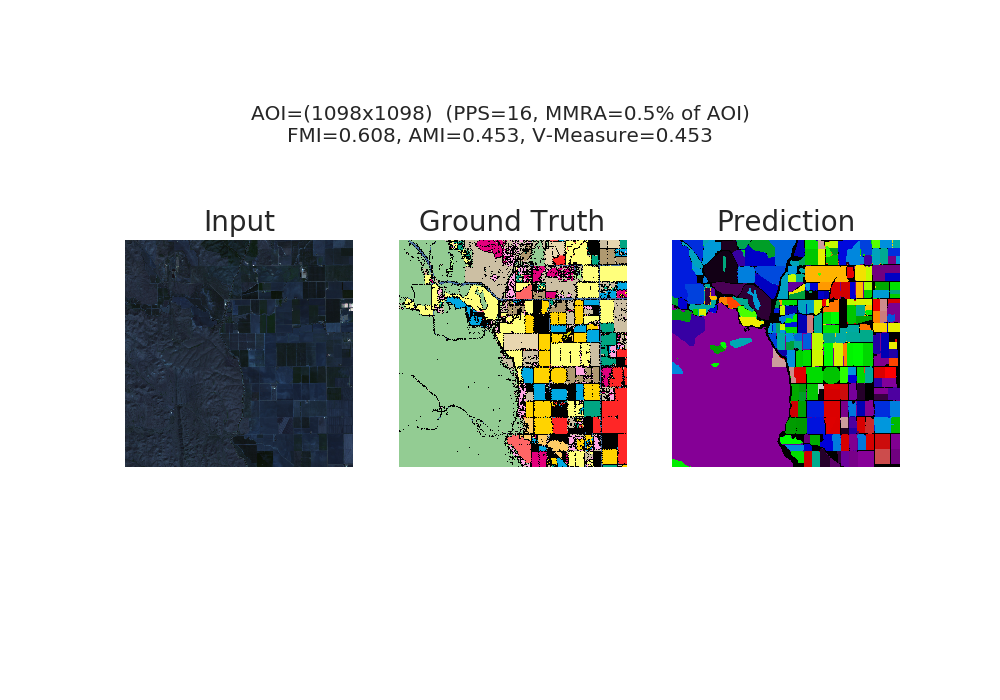

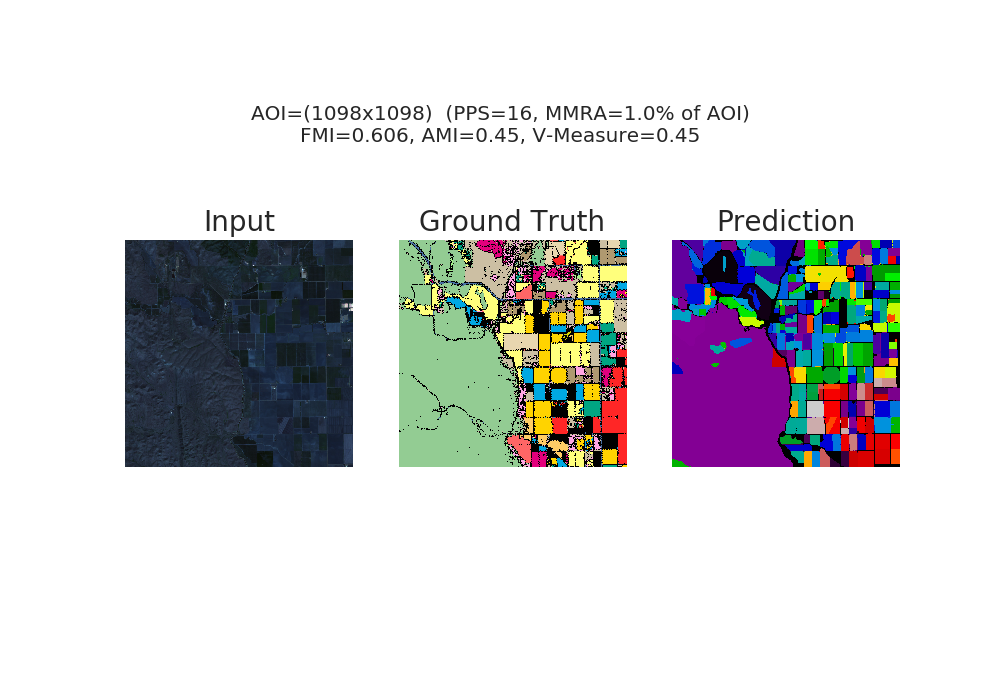

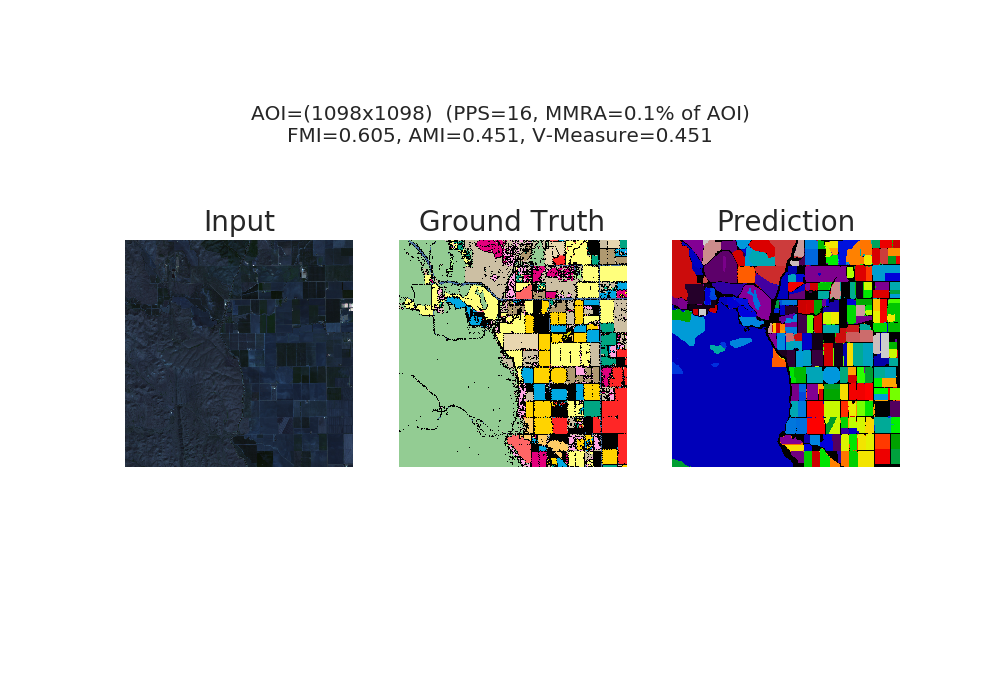

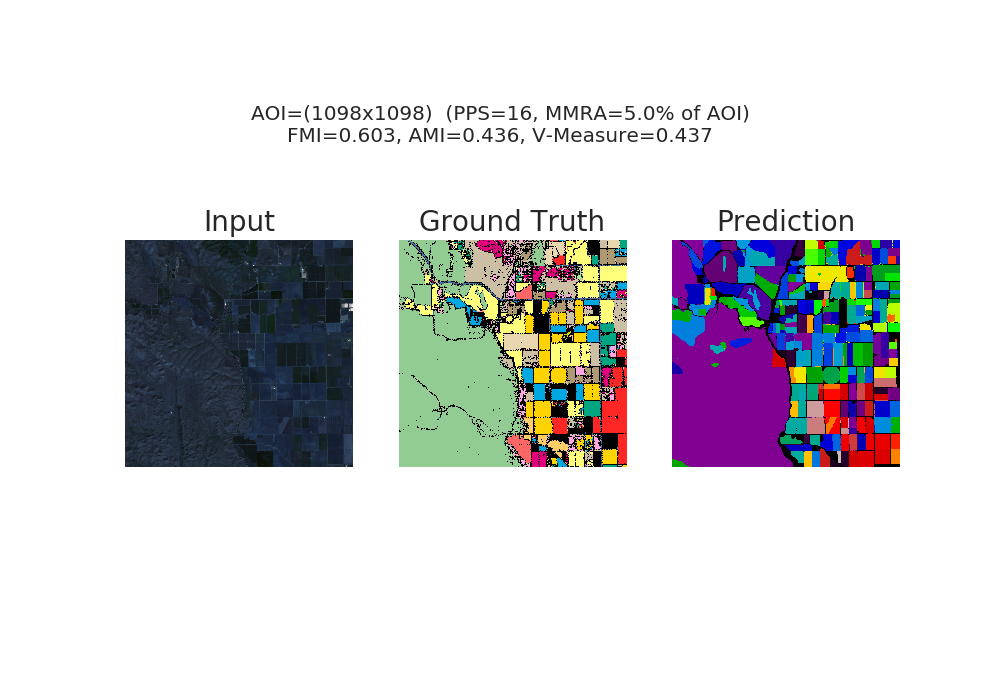

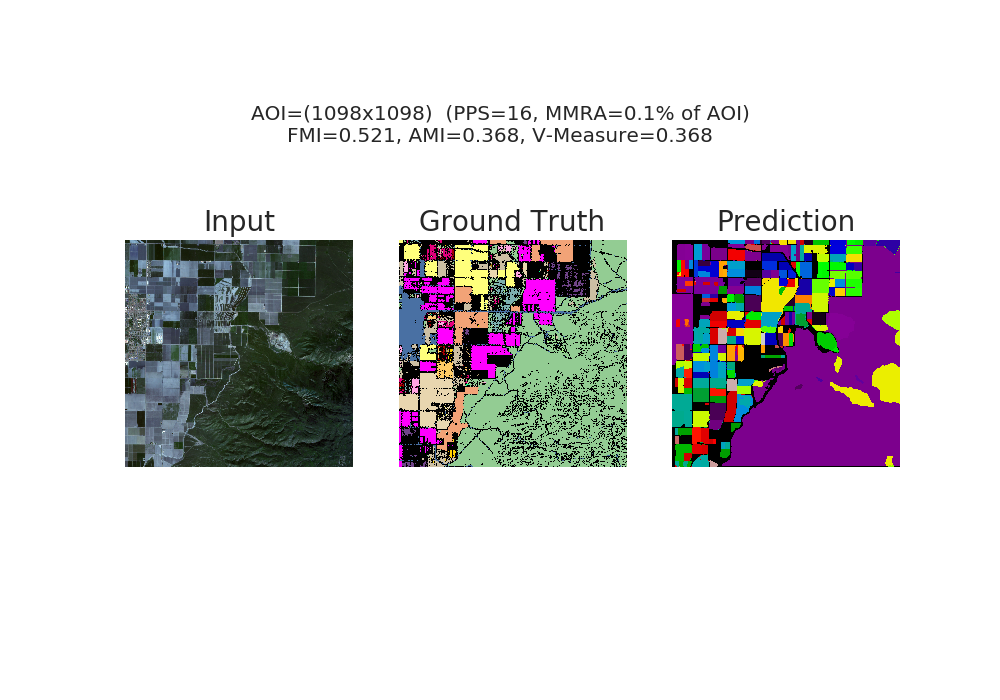

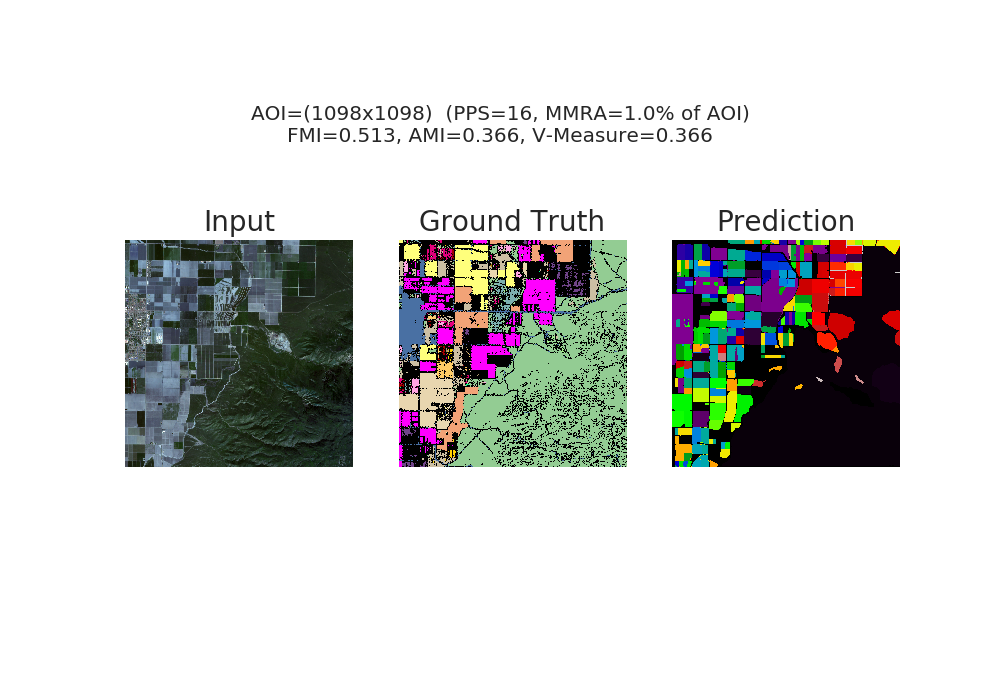

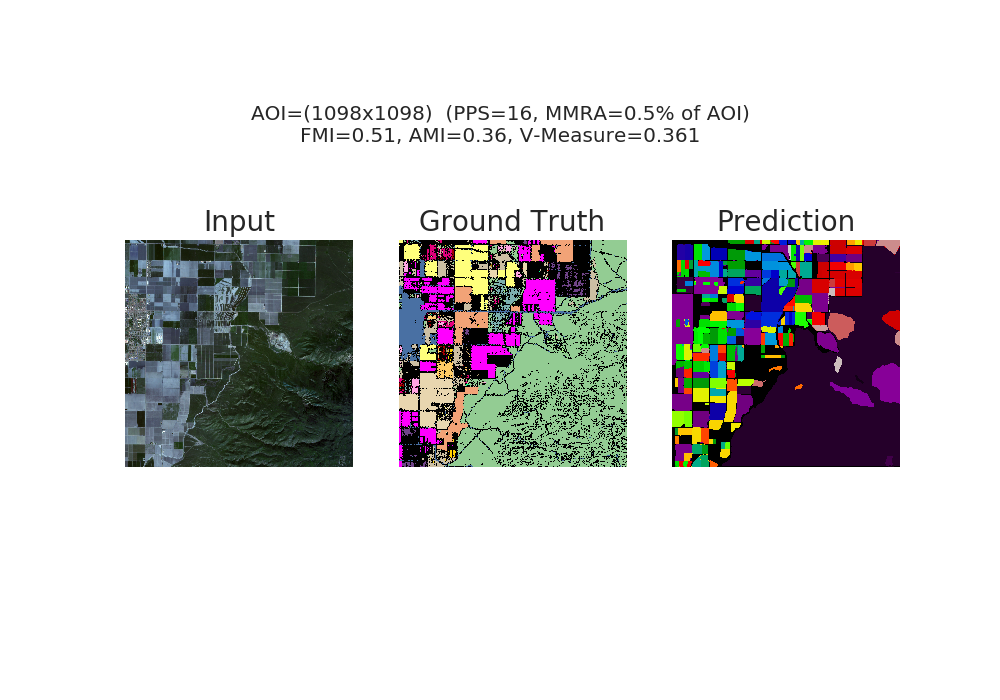

In [55]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.5, 0.99, inclusive=True)) 
                                & (results.AOI == 1098) 
                                & (results.PPS == 16)
                            ]
print(len(samples_to_display))

n=10
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(n)

for index, row in samples_to_display.iterrows():
    # print(row['sample_idx'], row['AOI'], row['PPS'], row['MMRA'], row['FMI'])
    aoi_size, mmra, pps, sample_id = int(row['AOI']), row['perc_MMRA'].round(1), int(row['PPS']), int(row['sample_idx'])
    filepath = RESULTS_DIR+"/grid_search/june2023/num_samples_{}/aoi_size_{}/mmra_{}/pps_{}/plots/sample_{}.png"\
                .format(num_samples, aoi_size, mmra, pps, sample_id)

    display(Image(filename=filepath))